# Digital Epidemiology - Epidemic Process on Gnutella p2p network
**Mauricio Fadel Argerich - Matricola 1739634**
***
## Part 1: Epidemic process on a social network
### 1.1. The graph
For this assignment the **Gnutella peer-to-peer network, August 9 2002** is used. The file is _automagically_ retrieved from SNAP within the code (no need to download it manually). For more information about the graph please visit __[this URL](http://snap.stanford.edu/data/p2p-Gnutella09.html)__. <br>
Since a network of computers is used, the epidemic can be thought of as a computer virus epidemic. Once the computer is infected by the virus, the virus is spread until the user runs an antivirus program and the computer is "recovered". <br>
First, let's import the graph using NetworkX and let's see some simple statistics about it:

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gzip
import urllib.request

def print_graph_stats(title, g):
    print("Simple stats for: " + title)
    print("# of nodes: " + str(len(g.nodes())))
    print("# of edges: " + str(len(g.edges())))
    print("Is graph connected? " + str(nx.is_connected(g)))
    
# Download file from SNAP and uncompress it.
response = urllib.request.urlopen('http://snap.stanford.edu/data/p2p-Gnutella09.txt.gz')
with open('p2p-Gnutella09.txt', 'wb') as outfile:
    outfile.write(gzip.decompress(response.read()))

g = nx.read_edgelist('p2p-Gnutella09.txt')
print_graph_stats("Gnutella p2p graph", g)

Simple stats for: Gnutella p2p graph
# of nodes: 8114
# of edges: 26013
Is graph connected? False


Since the graph is not connected, let's find its connected subcomponents. To continue the work I use the connected subcomponent with the most nodes. Fortunately, the largest connected subcomponent includes almost all of the nodes in the graph. <br>
A histogram with the degree distribution of the nodes is also plotted. It is possible to see that there are a few nodes that are "hubs" - which have a large number of links - and a large number of nodes that have a few edges.

Simple stats for: Gnutella p2p connected subgraph
# of nodes: 8104
# of edges: 26008
Is graph connected? True


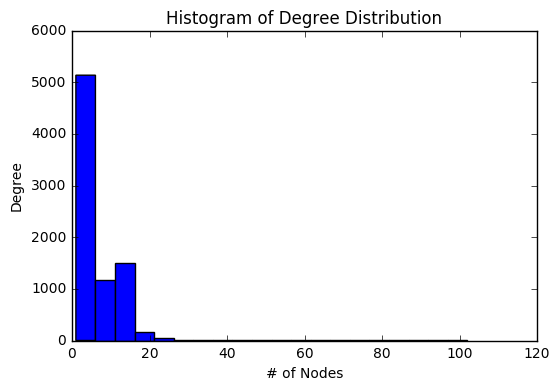

In [2]:
# Get the largest connected component
cg = None
for sg in nx.connected_component_subgraphs(g):
    if cg == None or len(sg.nodes()) > len(cg.nodes()):
        cg = sg
        
# Let's check the graph stats
print_graph_stats("Gnutella p2p connected subgraph", cg)

# Plot the nodes' degree destribution in a histogram.
plt.figure()
plt.title('Histogram of Degree Distribution')
plt.hist(list(nx.degree(cg).values()), bins=20)
plt.xlabel('# of Nodes')
plt.ylabel('Degree')
plt.show()

### 1.2. Simulating the SIR epidemic process
The class SIR is used in order to simulate the SIR epidemic process on the graph. WIth this class I run the SIR process using the parameters **$\beta$: transmission rate** and **$\mu$: recovery rate**. Then, the epidemic curve is plotted to see how fast the epidemic spreads in the graph. For a quick overview of the final results of the epidemic, let's also check the percentage of the recovered computers. This will tell us how many computers were infected by the virus during the whole time of the simulation. <br>
To find the best values for the parameters, the SIR model is run 100 times and then a histogram is plotted. This way it is possible to see how many times the epidemic _takes off_ in the simulations. I consider that the epidemic _takes off_ when the overall attack rate is greater than 90%. <br>
After several tests, the parameters chosen to allow the epidemic to take off with a high probability (P > 0.95) are: **$\beta$: 0.5** and **$\mu$: 0.2**.

In [3]:
class SIR:
    def __init__(self, g, beta, mu):
        self.g = g
        self.beta = beta
        self.mu = mu
        
    def run(self, seed=[], num_steps = 1, sentinels = [], immunization_rate = 0.0, immunized_nodes = []):
        # Immunize nodes according to the set immunization rate.
        if len(immunized_nodes) == 0:
            immunized = set(np.random.choice(self.g.nodes(), 
                                             size=int(immunization_rate*len(self.g.nodes())), 
                                             replace=False))
        else:
            immunized = immunized_nodes
        
        
        # If there is no seed, just choose a random node in the graph.
        if len(seed) == 0:
            seed = [np.random.choice(list(set(self.g.nodes()).difference(immunized)))]
        
        I_set = set(seed)
        S_set = set(self.g.nodes()).difference(I_set).difference(immunized)
        R_set = set()
        
        t = 0
        
        StoI = set(seed)
        ItoR = set()
        
        sentinels_t = {}
        for sen in sentinels:
            sentinels_t[sen] = 0
        
        while len(I_set) > 0:
            # Let's infect people! 
            for i in I_set.copy():
                for s in set(self.g.neighbors(i)).intersection(S_set).copy():
                    if np.random.uniform() < self.beta:
                        S_set.remove(s)
                        I_set.add(s)
                        StoI.add(s)
                        
                        # Record t for sentinels
                        if sentinels_t.get(s) != None:
                            sentinels_t[s] = t
                        
                # Will infected person recover?
                if np.random.uniform() < self.mu:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR.add(i)
    
            t += 1
            if t % num_steps == 0 or len(I_set) == 0:
                yield({'t': t, 'S':S_set, 'I':I_set, 'R':R_set, 'StoI':StoI, 'ItoR':ItoR, 'sentinels': sentinels_t})

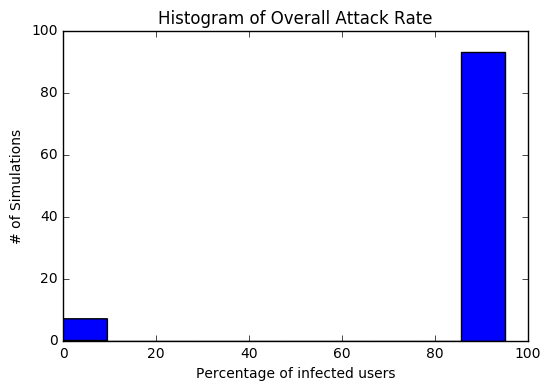

In [4]:
# Initialize the SIR epidemic model.
sir = SIR(cg, beta = 0.5, mu = 0.2)

final_rs = []

for i in range(0,100):
    simulation_steps = [[len(r['S']), len(r['I']), len(r['R'])] for r in sir.run(num_steps=1)]
    # Save the final R for each simulation.
    final_rs.append(simulation_steps[len(simulation_steps)-1][2]*100/len(cg.nodes()))
    
# Plot the results.
plt.figure()
plt.title('Histogram of Overall Attack Rate')
plt.hist(final_rs)
plt.xlabel('Percentage of infected users')
plt.ylabel('# of Simulations')
plt.show()

### 1.3. Probability distribution of the overall attack rate and peak times of epidemic
In order to see the behavior of the SIR process, the process is repeated 100 times and then the epidemic curves for the simulations are plotted. It is possible to see that most of the epidemics take off at an early stage, around time $t = 5$ and also that when the simulations are finished, the value of R is always high, which means that the overall attack rate is close to 1. <br>
Below it is possible to see the boxplots for the peak time of the infections - the time when $I$ has the greatest value - and for the overall attack rate. The peak time shows that the epidemic takes off quickly in most of the simulations, having a mean of $~7$ and the variation of the peak times is not big among the different simulations. Similarly, the attack rate is always high and quite well centered around 0.95. <br>
With the given parameters $\beta$ and $\mu$ the infection is quite effective.

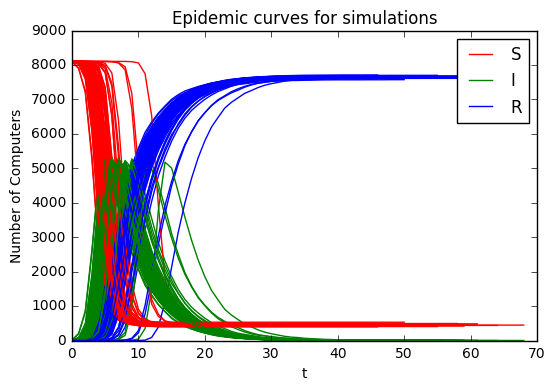

In [5]:
b = 0.5
m = 0.2

attack_rate = []
peak_times = []

# Set plot settings.
plt.figure()
ax = plt.subplot(111)
ax.set_prop_cycle('color', ['red', 'green', 'blue'])

# Run the simulation multiple times to average the results.
for i in range(0,100):
    sir = SIR(cg, beta = b, mu = m)
    
    I_peak = 0
    peak_t = 0
    res = []
    
    for r in sir.run(num_steps=1):
        res.append([len(r['S']), len(r['I']), len(r['R'])])
        if len(r['I']) > I_peak:
            I_peak = len(r['I'])
            peak_t = r['t']
        
    # Once the epidemic has ended let's record the stats
    attack_rate.append(len(r['R'])/len(cg.nodes()))
    peak_times.append(peak_t)
    
    # Plotting the epidemic curve.
    plt.plot(res)
    
# Plot the results.
plt.title("Epidemic curves for simulations")
plt.legend(['S', 'I', 'R'])
plt.xlabel("t")
plt.ylabel("Number of Computers")
plt.show()

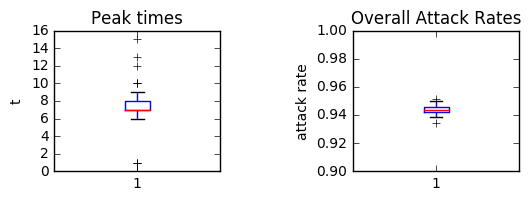

In [6]:
# Create boxplots for peak times and overall attack rates.
plt.subplots_adjust(wspace=0.8)
plt.subplot(221)
plt.title("Peak times")
plt.boxplot(peak_times)
plt.ylabel('t')
plt.subplot(222)
plt.title("Overall Attack Rates")
plt.boxplot(attack_rate)
plt.ylim(ymin = 0.9, ymax = 1.0)
plt.ylabel('attack rate')
plt.show()

***
## Part 2: Vaccination and herd immunity
### 2.1. Immunized nodes
There are two ways to indicate the SIR class model that there are immunized nodes:
- Indicating a rate of immunization in the population, in this case the immunized nodes are chosen randomly
- Indicating the group of nodes that are immunized, which is necessary to implement targeted vaccination methods.

Knowing the immunization rate, it is possible to calculate the theoretical upper bound for the overall attack (OAR) with the simple formula: <br>
$OAR_{max} = 1 - R_{immunization}$ <br><br>
In the case that $R_{immunization} = 0.2$, then the upper bound for the overall attack is <br>
$OAR_{max} = 1 - 0.2$<br>
$OAR_{max} = 0.8$

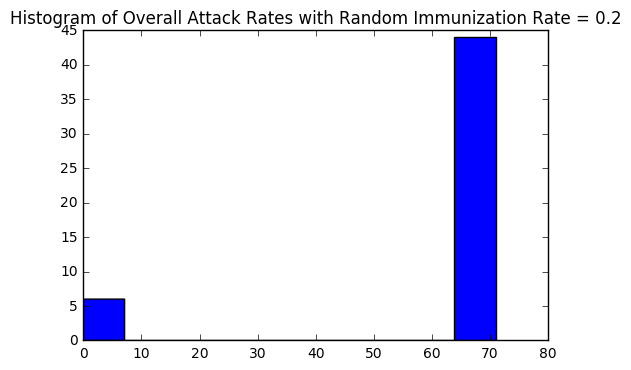

In [7]:
i_sir = SIR(cg, beta = b, mu = m)

final_rs = []

# Simulate the process multiple times with the same immunization rate.
for i in range(0,50):
    simulation_steps = [[len(r['S']), len(r['I']), len(r['R'])] for r in i_sir.run(num_steps=1, immunization_rate = 0.2)]
    # Save final attack rate (R: nodes that were infected and have recovered) for each simulation.
    final_rs.append(simulation_steps[len(simulation_steps)-1][2]*100/len(cg.nodes()))
    
# Plot the results.
plt.figure()
ax = plt.subplot(111)
plt.title('Histogram of Overall Attack Rates with Random Immunization Rate = 0.2')
plt.hist(final_rs)
plt.show()

### 2.2. Overall attack rate v. immunization rate
To see how the immunization rate affects the overall attack rate in the specific case of the graph, it is possible to simulate the epidemic with different immunization rates and then plot the overall attack rate through the different simulations. Also, it is a good idea to run the simulation multiple times for each immuzation rate since this is a stochastic process. <br>
It is noticeable how the immunization rates causes the overall attack rate to drop. In particular when the immunization rate is 0.6, the overall attack rate mean is around 0.2. This shows that even though the succeptible mass is 40% of the population, the epidemic does not affect half of them, because many of the contagions are stopped by the vaccinated nodes, which act like _barriers_ to the spread of the disease.

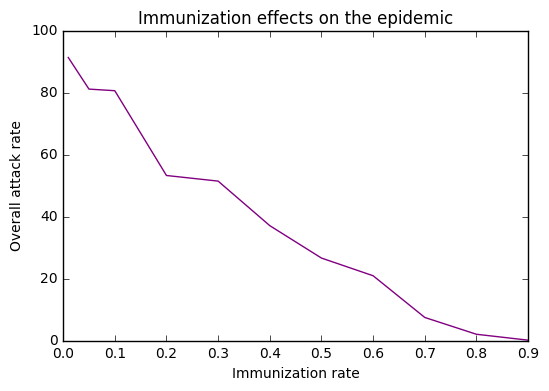

In [8]:
import operator

i_sir = SIR(cg, beta = b, mu = m)
immunization_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

final_rs = {}

for ir in immunization_rates:
    final_rs[ir] = []
    for i in range(0,50):
        simulation_steps = [[len(r['S']), len(r['I']), len(r['R'])] for r in i_sir.run(num_steps=1, 
                                                                                       immunization_rate = ir)]
        final_rs.get(ir).append(simulation_steps[len(simulation_steps)-1][2]*100/len(cg.nodes()))
        
sorted_ir = sorted(final_rs.items(), key=operator.itemgetter(0))
irs = []
oars = []
for ir, values in sorted_ir:
    irs.append(ir)
    oars.append(np.mean(values))
    
# Plot the results.
plt.title('Immunization effects on the epidemic')
plt.xlabel('Immunization rate')
plt.ylabel('Overall attack rate')
plt.subplot(111).set_prop_cycle('color', ['purple'])
plt.plot(irs, oars)
plt.show()

### 2.3. Trying it on an Erdős–Rényi graph
The Erdős–Rényi graph has a more balanced degree distribution in its nodes because each edge has a fixed probability of being present or absent, independently of the other edges. This can be observed in the Degree Distribution Histogram below, which is compared to the Degree Distribution for the Gnutella graph. There are no nodes with more than 17 edges in the Erdős–Rényi, while in the Gnutella there are some nodes with really high degree such as 100. <br>
Running the immunization simulation on the Erdős–Rényi has a different result, due to the non-existence of these high connected nodes. On the Gnutella graph the random immunization hits hubs sometimes and this improves the results. This is because immunizing nodes that are "hubs" is more effective than immunizing other nodes because these hubs are part of many critical paths to other nodes, and therefore the virus cannot spread if the hubs are immunized. On the Erdős–Rényi however, the degree distribution is more balanced so there are many critical paths for every node, making the spread of the virus harder to stop. This is observable in the plot below.

Simple stats for: Erdos-Renyi connected subgraph
# of nodes: 8091
# of edges: 26117
Is graph connected? True


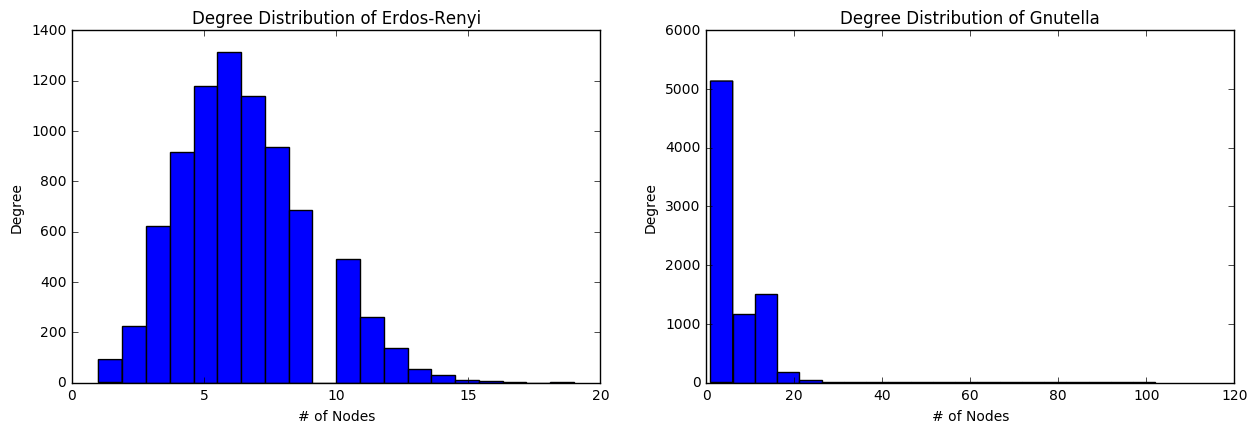

In [9]:
# Create an Erdős–Rényi graph with the same number of nodes and the same density
# as the original graph.
erg = nx.erdos_renyi_graph(len(cg.nodes()), nx.density(cg))

# Get the largest connected component of the Erdős–Rényi graph.
cerg = None
for sg in nx.connected_component_subgraphs(erg):
    if cerg == None or len(sg.nodes()) > len(cerg.nodes()):
        cerg = sg
        
# Let's check the graph stats
print_graph_stats("Erdos-Renyi connected subgraph", cerg)

# Plot degree distribution of Erdos-Renyi graph and compare it to Gnutella.
plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace=0.2)
plt.subplot(221)
plt.title('Degree Distribution of Erdos-Renyi')
plt.hist(list(nx.degree(cerg).values()), bins=20)
plt.xlabel('# of Nodes')
plt.ylabel('Degree')
plt.subplot(222)
plt.title('Degree Distribution of Gnutella')
plt.hist(list(nx.degree(cg).values()), bins=20)
plt.xlabel('# of Nodes')
plt.ylabel('Degree')
plt.show()

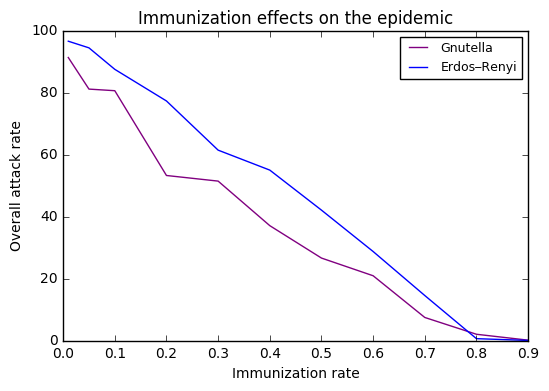

In [10]:
# Simulating the epidemic with immunization on the Erdős–Rényi graph.
i_sir = SIR(cerg, beta = b, mu = m)
immunization_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

final_rs = {}

# Run the simulation multiple times for each immunization rate.
for ir in immunization_rates:
    final_rs[ir] = []
    for i in range(0,50):
        simulation_steps = [[len(r['S']), len(r['I']), len(r['R'])] for r in i_sir.run(num_steps=1, 
                                                                                       immunization_rate = ir)]
        final_rs.get(ir).append(simulation_steps[len(simulation_steps)-1][2]*100/len(cg.nodes()))
        
# Sort the immunization rates and calculate the mean overall attack rate 
# over the simulations for each rate to plot them.
sorted_ir = sorted(final_rs.items(), key=operator.itemgetter(0))
irs_erg = []
oars_erg = []
for ir, values in sorted_ir:
    irs_erg.append(ir)
    oars_erg.append(np.mean(values))

# Plot the results.
plt.title('Immunization effects on the epidemic')
plt.xlabel('Immunization rate')
plt.ylabel('Overall attack rate')
plt.subplot(111).set_prop_cycle('color', ['purple', 'blue'])
plt.plot(irs, oars)
plt.plot(irs_erg, oars_erg)
plt.legend(['Gnutella', 'Erdos–Renyi'], fontsize = 9)
plt.show()

***
## Part 3: Targeted Vaccination Strategies
### 3.1. Targeted Immunization
In point 2.2 it's been shown that it is possible to stop an epidemic from occuring if a large number of nodes are randomly immunized. But if some criterion is used to choose the immunized nodes, instead of doing it an random, is it possible to improve the results with less immunized nodes? <br>
Obviously the answer is *yes*. The approach I will follow is to immunize the nodes that have the highest degree, i.e. the nodes that have the most edges to the rest of the nodes. These nodes will act as a barrier, stopping the spread of the infection among the nodes. The results of this strategy are illustrated in the plot below and for comparison, the random immunization results are also shown. <br>
Each strategy is tested with different immunization rates ranging from 1% to 90% of the graph. From the graph, it is observable that the highest degree strategy is far more effective than the random immunization. In particular, when the immunization rate is 30%, the overall attack rate mean of infected nodes over 50 simulations is almost 0 when using the targeted immunization, while for random immunization this rate is still around 50%.

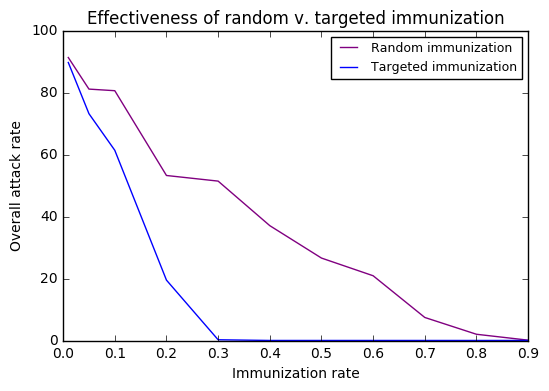

In [11]:
ti_sir = SIR(cg, beta = b, mu = m)

# Create a list with the nodes sorted by descending order of its degree.
nodes_sorted_by_degree = sorted(nx.degree(cg).items(), key=operator.itemgetter(1), reverse=True)
immunization_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

final_rs = {}

for ir in immunization_rates:
    final_rs[ir] = []
    
    # Immunize the M nodes with highest degree.
    immunized_nodes = []
    M = int(ir*len(nodes_sorted_by_degree))
    for i in range(M):
        immunized_nodes.append(nodes_sorted_by_degree[i][0])
    
    # Run the simulation 50 times and save the results.
    for i in range(0,50):
        simulation_steps = [[len(r['S']), len(r['I']), len(r['R'])] for r in ti_sir.run(num_steps=1, 
                                                                                        immunized_nodes = immunized_nodes)]
        final_rs.get(ir).append(simulation_steps[len(simulation_steps)-1][2]*100/len(cg.nodes()))
        
# Sort results and calculate the mean over the simulations to plot them.
sorted_ir = sorted(final_rs.items(), key=operator.itemgetter(0))
t_irs = []
t_oars = []
for ir, values in sorted_ir:
    t_irs.append(ir)
    t_oars.append(np.mean(values))
    
# Plot results.
plt.title('Effectiveness of random v. targeted immunization')
plt.xlabel('Immunization rate')
plt.ylabel('Overall attack rate')
plt.subplot(111).set_prop_cycle('color', ['purple', 'blue'])
plt.plot(irs, oars)
plt.plot(t_irs, t_oars)
plt.legend(['Random immunization', 'Targeted immunization'], fontsize = 9)
plt.show()

### 3.2. Only using simulation information
Even though the approach of immunizing the highest degree nodes in the graph is highly effective, it means that a lot of information about the network is needed. In most real cases, having this information is not feasible. So, now let's suppose we only count with information from the results of simulating the SIR on the network. What strategy can be used to optimize the effect of immunization with these data? <br>
In this case, the strategy I followed is to track the time $t$ when each node in the network is infected. After running the simulation multiple times and calculating the mean of $t$ for each node, I aim to immunize the nodes which get infected first. The reasoning behind it is that these nodes get infected _quickly_ because they are well connected to the other nodes, so the infection arrives early to them. In addition, as a double effect of being well connected, once they are infected they will spread the infection throughout the network. Because of this, immunizing these nodes improve the results of immunization in the graph. <br>
Once again, the results can be seen in the plot below. Although it is clear that this approach is not as effective as the highest degree immunization, the results are still much better than random immunization and this is achieved counting with less information than before.

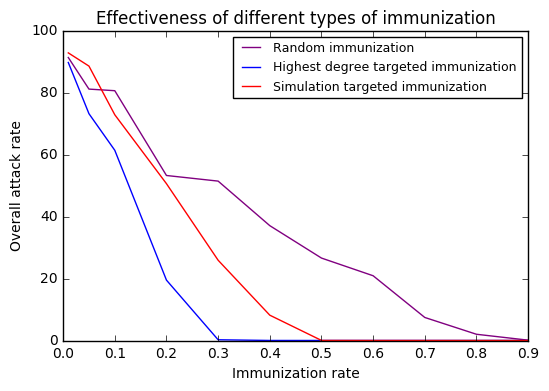

In [12]:
ti_sim_sir = SIR(g, beta = b, mu = m)
# The sentinels are all of the nodes in the graph.
sentinels = cg.nodes()
sentinels_results = {}

# First 50 simulations to find the nodes that are infected the quickest.
for i in range(0,50):
    status_sentinels = [status for status in ti_sim_sir.run(sentinels=sentinels)]
    if i == 0:
        sentinels_mid_res = status_sentinels[len(status_sentinels)-1].get('sentinels')
        for node, values in sentinels_mid_res.items():
            sentinels_results[node] = [sentinels_mid_res.get(node)]
    else:
        sentinels_mid_res = status_sentinels[len(status_sentinels)-1].get('sentinels')
        for node, values in sentinels_results.items():
            sentinels_results.get(node).append(sentinels_mid_res.get(node))
    
# Calculate the mean infection time for each node over the 50 simulations.
for node, values in sentinels_results.items():
    sentinels_results[node] = np.mean(values)
    
# Sort the list in ascending order, so the ones that are infected the first are
# vaccinated.
sentinels_sorted = sorted(sentinels_results.items(), key=operator.itemgetter(1))
immunization_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

final_rs = {}

# Simulations to test the approach.
for ir in immunization_rates:
    final_rs[ir] = []
    immunized_nodes = []
    M = int(ir*len(sentinels_sorted))
    for i in range(M):
        immunized_nodes.append(sentinels_sorted[i][0])
    
    for i in range(0,10):
        simulation_steps = [[len(r['S']), len(r['I']), len(r['R'])] for r in ti_sir.run(num_steps=1, 
                                                                                        immunized_nodes = immunized_nodes)]
        final_rs.get(ir).append(simulation_steps[len(simulation_steps)-1][2]*100/len(cg.nodes()))
        
# Sort results and calculate the mean over the simulations to plot them.
sorted_ir = sorted(final_rs.items(), key=operator.itemgetter(0))
t_sim_irs = []
t_sim_oars = []
for ir, values in sorted_ir:
    t_sim_irs.append(ir)
    t_sim_oars.append(np.mean(values))

# Plot results.
plt.title('Effectiveness of different types of immunization')
plt.xlabel('Immunization rate')
plt.ylabel('Overall attack rate')
plt.subplot(111).set_prop_cycle('color', ['purple', 'blue', 'red'])
plt.plot(irs, oars)
plt.plot(t_irs, t_oars)
plt.plot(t_sim_irs, t_sim_oars)
plt.legend(['Random immunization', 'Highest degree targeted immunization', 'Simulation targeted immunization'],
          fontsize = 9)
plt.show()

### 3.3. Limited information
But what happens when only a _small_ part of the graph is known? This is certainly the case for most epidemiologists in real life. <br>
When only $K$ nodes and its neighbors are known, a possible approach is to randomly immunize the neighbors of these $K$ nodes. This is known as _acquaintance immunization_; it might not seem to make sense at a glance, but the reasoning behind it is interesting and the results are impressive. <br>
The approach is based upon the probability of randomly selecting the "hubs" of the network to immunize them. Firstly a random selection of $K$ nodes is done. Since the "hubs" are connected to most of the nodes, it is very likely that some of these $K$ nodes are connected to the "hubs". Following this logic, random sampling the neighbors of the $K$ nodes has a higher probability of finding "hubs" than random sampling nodes from the graph as in the first step. This is why immunizing the neighbors is more effective than immunizing the $K$ nodes. A more detailed explanation can be found in _Cohen, Reuven and Havlin, Shlomo and ben-Avraham, Daniel [Efficient Immunization Strategies for Computer Networks and Populations]_. <br>
In the plot below the effectiveness of the approach is shown and compared to the strategies used in previous points. The best approach remains to be the highest degree one, but the second most effective strategy is aquaintance immunization. This is surprising if we take into account how little information is known for this approach as oppossed to the all-knowing highest degree immunization.

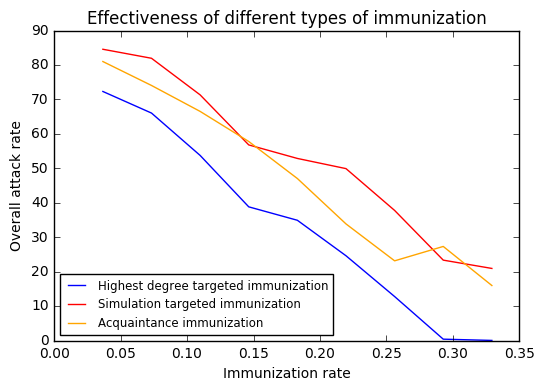

In [13]:
K = 0.1
known_nodes = set(np.random.choice(cg.nodes(), size=int(K*len(cg.nodes())), replace=False))
neighbors = set()
for node in list(known_nodes):
    neighbors.update(set(cg.neighbors(node)))

immunization_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

final_rs_k = {}
final_rs_deg = {}
final_rs_sim = {}

for ir in immunization_rates:
    final_rs_k[ir] = []
    final_rs_deg[ir] = []
    final_rs_sim[ir] = []
    M = int(ir*len(neighbors))
    immunized_nodes_k = set(np.random.choice(list(neighbors), size=M, replace=False))
    # To compare this approach with highest degree and limited information techniques.
    immunized_nodes_deg = []
    immunized_nodes_sim = []
    for i in range(M):
        immunized_nodes_deg.append(nodes_sorted_by_degree[i][0])
        immunized_nodes_sim.append(sentinels_sorted[i][0])
    
    for i in range(0,50):
        # Acquaintance immunization
        simulation_steps_k = [[len(r['S']), len(r['I']), len(r['R'])] for r in ti_sir.run(num_steps=1, 
                                                                                        immunized_nodes = immunized_nodes_k)]
        final_rs_k.get(ir).append(simulation_steps_k[len(simulation_steps_k)-1][2]*100/len(cg.nodes()))
        
        # Highest degree immunization
        simulation_steps_deg = [[len(r['S']), len(r['I']), len(r['R'])] for r in ti_sir.run(num_steps=1, 
                                                                                        immunized_nodes = immunized_nodes_deg)]
        final_rs_deg.get(ir).append(simulation_steps_deg[len(simulation_steps_deg)-1][2]*100/len(cg.nodes()))
        
        # Limited information immunization
        simulation_steps_sim = [[len(r['S']), len(r['I']), len(r['R'])] for r in ti_sir.run(num_steps=1, 
                                                                                        immunized_nodes = immunized_nodes_sim)]
        final_rs_sim.get(ir).append(simulation_steps_sim[len(simulation_steps_sim)-1][2]*100/len(cg.nodes()))
        
sorted_ir_k = sorted(final_rs_k.items(), key=operator.itemgetter(0))
irs = []
oars_k = []
oars_deg = []
oars_sim = []
for ir, values in sorted_ir_k:
    irs.append((ir*len(neighbors))/len(cg.nodes()))
    oars_k.append(np.mean(values))
    oars_deg.append(np.mean(final_rs_deg.get(ir)))
    oars_sim.append(np.mean(final_rs_sim.get(ir)))
    
plt.title('Effectiveness of different types of immunization')
plt.xlabel('Immunization rate')
plt.ylabel('Overall attack rate')
plt.subplot(111).set_prop_cycle('color', ['blue', 'red', 'orange'])
plt.plot(irs, oars_deg)
plt.plot(irs, oars_sim)
plt.plot(irs, oars_k)
plt.legend(['Highest degree targeted immunization', 
            'Simulation targeted immunization', 'Acquaintance immunization'],
          loc = 3, fontsize = 8.5)
plt.show()

## Sources
- Cattuto, Paoloti. Lecture material from Digital Epidemiology Course, 2017.
- Cohen, Reuven and Havlin, Shlomo and ben-Avraham, Daniel. Efficient Immunization Strategies for Computer Networks and Populations. Physical Review Letters, 2003.
- Leskovec, Kleinberg and Faloutsos. Graph Evolution: Densification and Shrinking Diameters. ACM Transactions on Knowledge Discovery from Data (ACM TKDD), 1(1), 2007.
- NetworkX Developers. NetworkX Official Documentation. Retrieved from https://networkx.github.io/documentation/stable/, December 2017.
- Ripeanu and Foster and Iamnitchi. Mapping the Gnutella Network: Properties of Large-Scale Peer-to-Peer Systems and Implications for System Design. IEEE Internet Computing Journal, 2002.
- Wikipedia. Erdős–Rényi model. Retrieved from https://en.wikipedia.org/wiki/Erdős–Rényi_model, 2017.